<h1><center>MLab - Computational Physics</center></h1>
<h2><center>Quantum Circuits: Quantum Dynamics and Circuit Emulator</center></h2>

Loading the required packages for the project.

In [1]:
using SparseArrays
using Expokit
using LinearAlgebra
using FastExpm
using Plots
using Statistics
using LaTeXStrings
using FFTW
using StatsBase

Defininf a function to convert a binary array to decimal for convenience in order to get integer index for easier manipulation of the matrix products.

In [2]:
function todecimal(binary_array)
    decimal = 0; N = length(binary_array)
    j = findfirst(==(1), binary_array)
    if j != nothing
        for i in j:N
            decimal += (2^(N-i))*binary_array[i]
        end
    else
        decimal = 0
    end
    return decimal
end

todecimal (generic function with 1 method)

In [3]:
function mat_exp(M)
    if iszero(M) == true
        return Diagonal(ones(size(M)[1],size(M)[2]))
    else
        return sparse(fastExpm(M))
    end
end

mat_exp (generic function with 1 method)

Defining the function for a one qubit gate acting on an N-qubit space as prescribed in the manual.

In [4]:
function one_qubit_gate(gate, qubit_label, index; N = 2)

    row_index = digits(index-1, base = 2, pad = N) |> reverse
    col_index = Int64[]
    indices = Any[]
    matrix_elements = Any[]

    for j in 1:qubit_label
        if j != qubit_label
            push!(col_index, row_index[j])
        else
            B = Any[]
            k = row_index[j]+1
            B = rowvals(gate[k,:])
            for l in 1:length(B)
                push!(indices, push!(copy(col_index),B[l]-1))
                indices[l] = cat(indices[l], row_index[j+1:N], dims = (1,1))
                indices[l] = todecimal(indices[l]) + 1
            end
            matrix_elements = cat(matrix_elements, nonzeros(gate[k,:]), dims = (1,1))
        end
    end
            
    return indices, matrix_elements
end

one_qubit_gate (generic function with 1 method)

Defining the function for a two qubit gate acting on an N-qubit space as prescribed in the manual.

In [5]:
function two_qubit_gate(gate, qubit_labels, index; N = 2)
    
    sort!(qubit_labels)
    i, j = qubit_labels
    row_index = digits(index-1, base = 2, pad = N) |> reverse
    col_index = Any[]
    indices = Any[]
    matrix_elements = Any[]
    
    for k in 1:i
        if k != i
            push!(col_index, row_index[i])
        else
            B = Any[]
            m = todecimal([row_index[i],row_index[j]]) + 1
            A = rowvals(gate[m,:])
            for n in 1:length(A)
                push!(B, digits(A[n]-1, base = 2, pad = N) |> reverse)
            end
            
            C = Any[]
            for l in 1:length(B)
                C = cat(copy(col_index), B[l], dims = (1,1))
                push!(indices, C)
                indices[l] = cat(indices[l], row_index[j+1:N], dims = (1,1))
                splice!(indices[l], i:i-1, row_index[i+1:j-1])
                indices[l] = todecimal(indices[l]) + 1
            end
            matrix_elements = cat(matrix_elements, nonzeros(gate[m,:]), dims = (1,1))
        end
    end
    
    return indices, matrix_elements
end

two_qubit_gate (generic function with 1 method)

Function to compute $\exp{(-i\Delta t A^{(i)})}$, where, $\prod_i \exp{(-i\Delta t A^{(i)})} = \exp{(-i\Delta t A)}$

In [6]:
function A1(Δt; J, h_z)
    A = J*kron(Z,Z) + (h_z/2)*(kron(Z,I) + kron(I,Z))
    if length(nonzeros(sparse(A))) == 0
        return kron(I,I)
    else
        return sparse(fastExpm(-im*A*Δt))
    end
end

A1 (generic function with 1 method)

Function to compute $\exp{(-i\Delta t B^{(i)}/2)}$, where, $\prod_i \exp{(-i\Delta t B^{(i)}/2)} = \exp{(-i\Delta t B/2)}$

In [7]:
function B1(Δt; h_x)
    B = (h_x/2)*X
    if length(nonzeros(sparse(B))) == 0
        return I
    else
        return sparse(fastExpm(-im*B*Δt))
    end
end

B1 (generic function with 1 method)

The generic functions above are defined only for demonstrative purposes. The actual computations necessary for the gate applications are just as efficient, if not more by direct computation using the sparse matrices with the **SparseArrays** package in Julia. Furthermore, this advantage is lost and significantly so in the usual matrix exponentiation as sparsity of a matrix isn't necessarily preserved under such an operation. Using the package **Expokit** (originally developed for Fortran and Matlab) makes the computation much more efficient due to clever numerical approximations.

Below, we define our first function that we actually use, which is the Hamiltonian for a Quantum Ising Chain which takes in the keyword arguments **J**, **h_x** and **h_z**, i.e, coupling, x-component of magnetic field and z-component of magnetic field respectively. It also has the default keyword argument **N = 2** which is the minimum system size relevant to the problem. By using the **circsfhift()** function we are able to define it subject to the given **PBCs**.

In [9]:
function Hamiltonian(;J, h_x, h_z, N = 2)
    
    Z = sparse([1 0; 0 -1])
    X = sparse([0 1; 1 0])
    I = sparse([1 0; 0 1])

    A2 = fill(I, N)
    A2[1] = Z
    A2[2] = Z
    
    A1 = fill(I, N)
    A1[1] = Z
    
    B = fill(I, N)
    B[1] = X
    
    H_A = spzeros(Int, 2^N, 2^N)
    H_B = spzeros(Int, 2^N, 2^N)
    
    for i in 1:N
        H_A -= J*foldl(kron, A2)
        H_A -= h_z*foldl(kron, A1)
        H_B -= h_x*foldl(kron, B)
        A2 = circshift(A2,1)
        A1 = circshift(A1,1)
        B = circshift(B,1)
    end
    
    return H_A, H_B
end

Hamiltonian (generic function with 1 method)

Function to compute direct time evolution of the system subject to the above Hamiltonian. This is a useful function that helps us benchmark our trotterisation as we will see in **Task 2**.

In [10]:
function time_evolve(t; parameters, N = 2)
    ψ = zeros(2^N)
    ψ[2^N] = 1
    J, h_x, h_z = parameters
    A, B = Hamiltonian(J = J, h_x = h_x, h_z = h_z, N = N)
    H = A + B
    return expmv(-im*t, H, ψ)
end

time_evolve (generic function with 1 method)

## Task 1

We start this task by defining a function to estimate the state of the system after a single trotter-step $\Delta t$.

In [10]:
function TS2_est(Δt; parameters, N = 2)
    ψ_0 = zeros(2^N)
    ψ_0[2^N] = 1
    J, h_x, h_z = parameters
    A, B = Hamiltonian(J = J, h_x = h_x, h_z = h_z, N = N)
    ψ_1 = expmv(-im*Δt/2, B, ψ_0)
    ψ_2 = expmv(-im*Δt, A, ψ_1)
    ψ = expmv(-im*Δt/2, B, ψ_2)
    
    return ψ
end

TS2_est (generic function with 1 method)

Note that the above function not only takes the parameters, i.e, keyword arguments **J**, **h_x** and **h_z**, but also the system size. We compute the time elapsed as a result of evaluating this trotter step for system sizes in the range $6 \leq L \leq 20$.

In [11]:
T1 = zeros(15)
for k in 6:20    
    T1[k-5] = @elapsed ψ_Δt = TS2_est(0.1, parameters = [1, 0.3, 0.5], N = k)
end

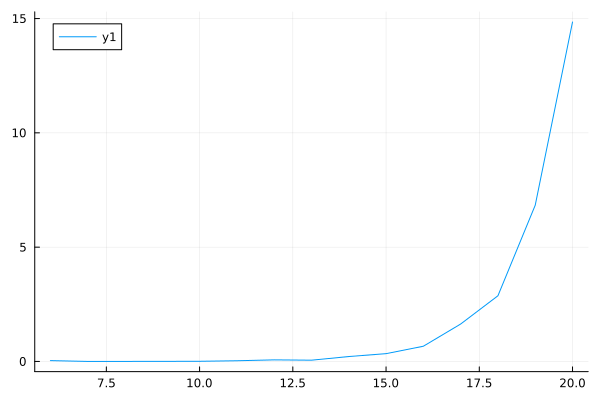

In [12]:
plot(collect(6:20),T1)

While the optimal maximal size is $16$ according to the plot, we choose $L = 10$ to illustrate the results as it is still non-trivial and encapsulates the same physics, but much faster for the machine to work with. The above curve is of course, subject to the processing power of the machine at hand. Thus, it is in principle possible that larger system sizes can be analysed quicker and thus the following code-block which sets the system size for the rest of the project can be edited by the user in order to do so.

In [10]:
L = 10

10

## Task 2

The following function computes a trotterised evolution for any input state $\psi_0$ for a trotter step $\Delta t$.

In [11]:
function TS2(Δt::Float64; parameters, ψ_0, N = L)
    J, h_x, h_z = parameters
    A, B = Hamiltonian(J = J, h_x = h_x, h_z = h_z, N = N)
    ψ_1 = expmv(-im*Δt/2, B, ψ_0)
    ψ_2 = expmv(-im*Δt, A, ψ_1)
    ψ = expmv(-im*Δt/2, B, ψ_2)
    
    return ψ
end

TS2 (generic function with 1 method)

Now, for the given set of parameters, we compute the overlap probability of the trotterised time evolution of the ground state with the direct time evolution to set the number of steps and step-size for the best results.

In [11]:
params = [1.0, 0.5, 0.0]
t = 25
ψ_t = time_evolve(t; parameters = params, N = L)
overlap = Float64[]

for n in 1:t*10
    ψ = zeros(2^L)
    ψ[2^L] = 1
    for i in 1:n
        ψ = TS2(t/n, parameters = params, ψ_0 = ψ)
    end
    push!(overlap, abs2(dot(ψ_t,ψ)))
end

println("The maximum probability of overlap is: ", findmax(overlap)[1])
println("For n = ", findmax(overlap)[2])

The maximum probability of overlap is: 0.9977470515037734
For n = 250


As expected, best results are obtained for the smallest $\Delta t$. Henceforth, we fix time $t = 25$ and since $\Delta t = \frac{t}{n} = \frac{t}{10t} = 0.1$, we will fix $n = 10t$ as well.

## Task 3

For the following two tasks we require a function for the expected magnetisation and a correlation function as well, which we define below.

In [15]:
function magnetisation(index; ψ_t, N = L)
    i = index
    
    Z = sparse([1 0; 0 -1])
    I = sparse([1 0; 0 1])
    
    m = fill(I, N)
    m[i] = Z
    M = spzeros(Int, 2^N, 2^N)
    
    M += foldl(kron,m)
    
    return dot(ψ_t, M, ψ_t)
end

magnetisation (generic function with 1 method)

In [16]:
function correlation_function(index1, index2; ψ_t, N = L)
    i = index1
    j = index2
    
    M_i = magnetisation(i,ψ_t = ψ_t)
    M_j = magnetisation(j,ψ_t = ψ_t)
    
    Z = sparse([1 0; 0 -1])
    I = sparse([1 0; 0 1])
    
    c = fill(I, N)
    c[i] = Z
    c[j] = Z
    C = spzeros(Int, 2^N, 2^N)
    
    C += foldl(kron,c)
    C_ij = dot(ψ_t, C, ψ_t) - (M_i)*(M_j)
    
    return C_ij
end

correlation_function (generic function with 1 method)

Furthermore, we define a function to compute the spatiotemporal build-up of correlations, i.e, $C(x,t)$. However, instead of taking the time as an argument as it would seem, we pass the state at that time $\psi_t$ instead.

In [17]:
function C(x; ψ_t, N = L)
    C = zeros(N)
    for i in 1:N
        if i+x <= N
            j = i+x
            C[i] = correlation_function(i,j,ψ_t = ψ_t)
        else
            j = (i+x)-N
            C[i] = correlation_function(i,j,ψ_t = ψ_t)
        end
    end
    return mean(C)
end

C (generic function with 1 method)

Now, for task 3, we have an array of three sets of parameters for which we compute $M^i(t)$ and $C(x,t)$.

In [18]:
params3 = [[1.0, 0.25, 0.0], [1.0, 0.5, 0.0], [1.0, 0.75, 0.0]] # params = [J, h_x, h_z]
M3 = Any[]
C3 = Any[]

for k in 1:3
    M = Any[]
    A = Any[]
    n = t*10 # From the overlap we calculated earlier
    ψ = zeros(2^L)
    ψ[2^L] = 1
    
    for i in 1:n
        ψ = TS2(t/n, parameters = params3[k], ψ_0 = ψ)
        M_j = Float64[]
        for j in 1:L
            push!(M_j, magnetisation(j, ψ_t = ψ))
        end
        push!(M, M_j)
    end
    
    for j in 1:L
        push!(A, [M[i][j] for i in 1:n])
    end
    push!(M3,A)
    
    C_xt = Any[]
    for x in 1:L-1
        C_t = Float64[]
        ψ = zeros(2^L)
        ψ[2^L] = 1
        for i in 1:n
            ψ = TS2(t/n, parameters = params3[k], ψ_0 = ψ)
            push!(C_t, C(x, ψ_t = ψ))
        end
        push!(C_xt, C_t)
    end
    push!(C3, C_xt)
end

And below, we generate the necessary plots. Notice that the magnetisation plot has been generated for the fourth qubit, i.e, for M3[k]**[4]**. The user can of course, change which site we are evaluating on, by changing the index. However, as a result of the symmetry of the system in the ground state, they should produce identical results.

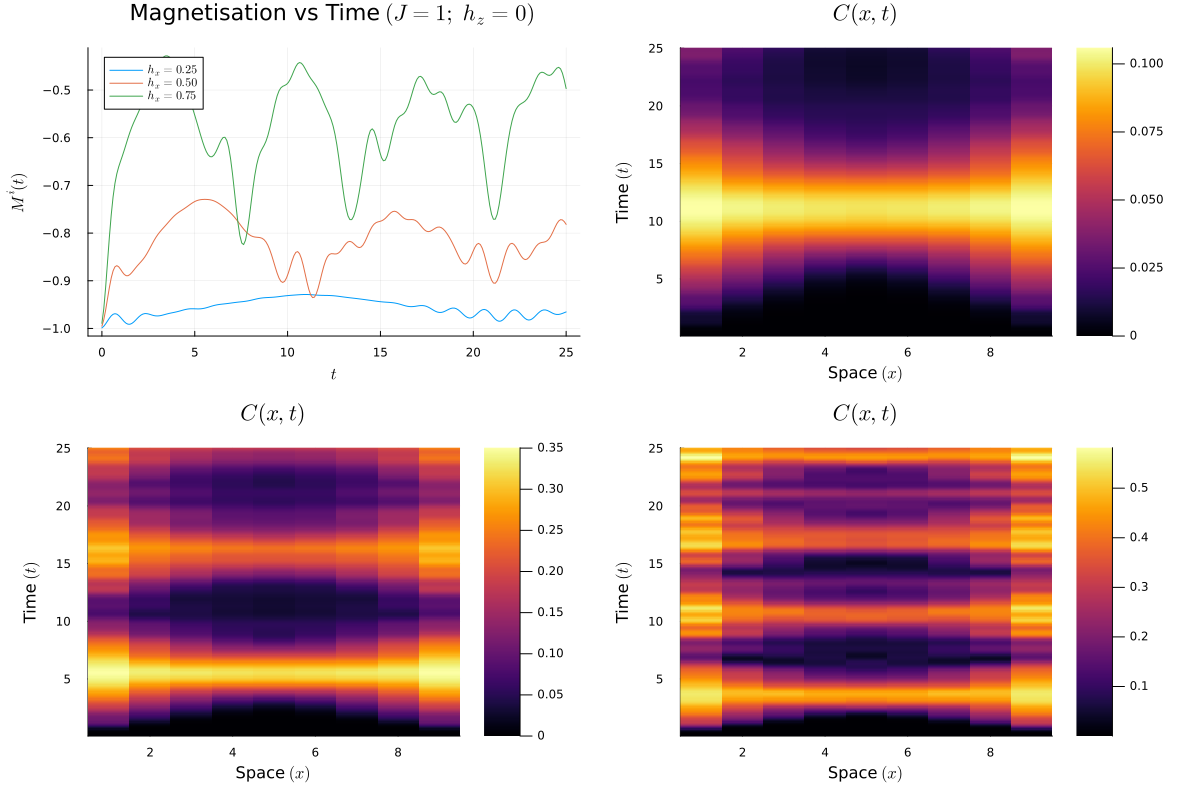

In [14]:
time = range(0, 25, length = 250)
gr()
P = Any[0,0,0,0]
l = [L"h_x = 0.25" L"h_x = 0.50" L"h_x = 0.75"]

P[1] = plot(time, M3[1][4], label = l[1])
for k in 2:3
    plot!(time, M3[k][4], label = l[k])
    title!(L"Magnetisation vs Time $(J = 1; \ h_z = 0)$", titlefontsize = 15)
    xlabel!(L"$t$")
    ylabel!(L"$M^i(t)$")
end

for k in 1:3
    data = Any[]
    data = hcat(C3[k]...)
    P[k+1] = heatmap(1:size(data,2),
        0.1:0.1:size(data,1)*0.1, data, c=:auto,
        xlabel=L"Space $(x)$", ylabel=L"Time $(t)$",
        title=L"$C(x,t)$", titlefontsize = 15)
end

plot(P[1],P[2],P[3],P[4],layout = 4, size = (1200,800), margin = 5*Plots.mm)

In [15]:
savefig("Task 3")

"D:\\M.Sc. Courses\\3. SoSe 2022\\4. Data Analysis in Physics and Astronomy\\Exercises\\Task 3.png"

As we can see from the magnetisation over time, the magnetisation has a crudely periodic nature with amplitudes becoming more pronounced as you tune the longitudinal component of the external field higher. The correlation heatmaps also grow denser as a result and exhibit a periodicity as well with local minima appearing at the center of the chain.

## Task 4

Now, for task 4, we have a different array of three sets of parameters for which we compute $M^i(t)$ and $C(x,t)$.

In [16]:
params4 = [[1.0, 0.2, 0.15], [1.0, 0.2, 0.30], [1.0, 0.2, 0.45]] # params4 = [J, h_x, h_z]
M4 = Any[]
C4 = Any[]

for k in 1:3
    M = Any[]
    A = Any[]
    n = t*10 # From the overlap we calculated earlier
    ψ = zeros(2^L)
    ψ[2^L] = 1
    
    for i in 1:n
        ψ = TS2(t/n, parameters = params4[k], ψ_0 = ψ)
        M_j = Float64[]
        for j in 1:L
            push!(M_j, magnetisation(j, ψ_t = ψ))
        end
        push!(M, M_j)
    end
    
    for j in 1:L
        push!(A, [M[i][j] for i in 1:n])
    end
    push!(M4,A)
    
    C_xt = Any[]
    for x in 1:L-1
        C_t = Float64[]
        ψ = zeros(2^L)
        ψ[2^L] = 1
        for i in 1:n
            ψ = TS2(t/n, parameters = params4[k], ψ_0 = ψ)
            push!(C_t, C(x, ψ_t = ψ))
        end
        push!(C_xt, C_t)
    end
    push!(C4, C_xt)
end

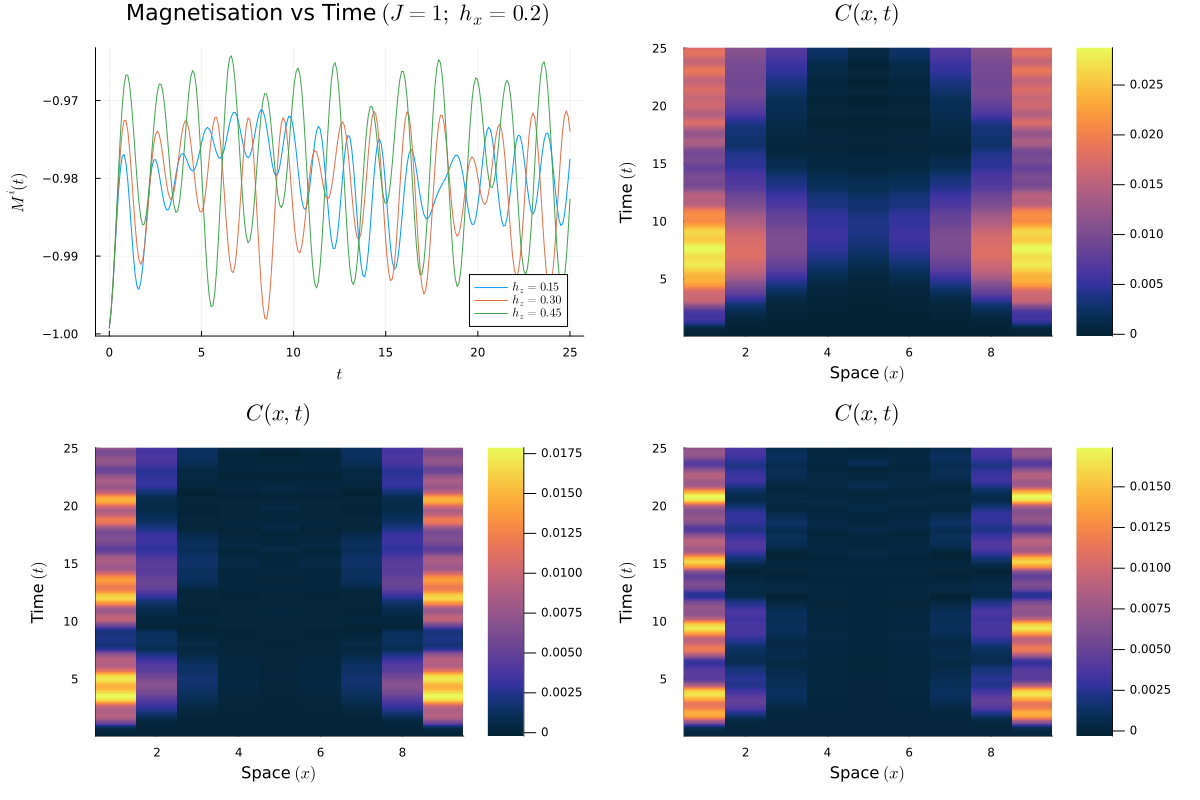

In [17]:
time = range(0, 25, length = 250)
gr()
P = Any[0,0,0,0]
l = [L"h_z = 0.15" L"h_z = 0.30" L"h_z = 0.45"]

P[1] = plot(time, M4[1][4], label = l[1])
for k in 2:3
    plot!(time, M4[k][4], label = l[k])
    title!(L"Magnetisation vs Time $(J = 1; \ h_x = 0.2)$", titlefontsize = 15)
    xlabel!(L"$t$")
    ylabel!(L"$M^i(t)$")
end

for k in 1:3
    data = Any[]
    data = hcat(C4[k]...)
    P[k+1] = heatmap(1:size(data,2),
        0.1:0.1:size(data,1)*0.1, data,
        c= :thermal,
        xlabel=L"Space $(x)$", ylabel=L"Time $(t)$",
        title=L"$C(x,t)$", titlefontsize = 15)
end

plot(P[1],P[2],P[3],P[4],layout = 4, size = (1200,800), margin = 5*Plots.mm)

In [18]:
savefig("Task 4")

"D:\\M.Sc. Courses\\3. SoSe 2022\\4. Data Analysis in Physics and Astronomy\\Exercises\\Task 4.png"

In this case, we see that the magnetisation has a periodic nature as well with amplitudes becoming more pronounced as you tune the transverse component of the external field higher. However, the periodic behaviour is far more sharp than the crudely periodic nature we see in the previous case. From the heatmaps one can also see correlated domain walls being formed periodically.

## Task 5

For this task we define a function that calculates the entanglement entropy for a given state based on the prescription provided. 

In [19]:
function entanglement_entropy(ψ)
    n_A = Int(floor(log2(length(ψ))/2))
    n_B = Int(ceil(log2(length(ψ))/2))
    ψ_2 = reshape(ψ,(2^(n_A),2^(n_B)))
    
    ψ_s = svd(ψ_2)
    Λ = ψ_s.S
    S_ent = 0
    
    for m in length(Λ)
        S_ent -= (Λ[m]^2)*log(Λ[m]^2)
    end
    
    return S_ent
end

entanglement_entropy (generic function with 1 method)

Computing entanglement entropy with respect to time for the parameters in **Task 3** and generating the plot.

In [20]:
S3 = Any[]
for k in 1:3
    S = Any[]
    ψ = zeros(2^L)
    ψ[2^L] = 1
    t = 25
    n = t*10
    for i in 1:n
        ψ = TS2(t/n, parameters = params3[k], ψ_0 = ψ)
        push!(S, entanglement_entropy(ψ))
    end
    push!(S3, S)
end

In [21]:
time = range(0, 25, length = 250)
gr()
En1 = Any[0,0,0]

l = [L"h_x = 0.25" L"h_x = 0.50" L"h_x = 0.75"]

for k in 1:3
    En1[k] = plot(time, S3[k], label = l[k])
    title!(L"Evolution of Entanglement Entropy $(J = 1; \ h_z = 0)$", titlefontsize = 10)
    xlabel!(L"$t$")
    ylabel!(L"$S(t)$")
end

Computing entanglement entropy with respect to time for the parameters in **Task 4** and generating the plot.

In [22]:
S4 = Any[]
for k in 1:3
    S = Any[]
    ψ = zeros(2^L)
    ψ[2^L] = 1
    t = 25
    n = t*10
    for i in 1:n
        ψ = TS2(t/n, parameters = params4[k], ψ_0 = ψ)
        push!(S, entanglement_entropy(ψ))
    end
    push!(S4, S)
end

In [23]:
time = range(0, 25, length = 250)
gr()
En2 = Any[0,0,0]

l = [L"h_z = 0.15" L"h_z = 0.30" L"h_z = 0.45"]

for k in 1:3
    En2[k] = plot(time, S4[k], label = l[k])
    title!(L"Evolution of Entanglement Entropy $(J = 1; \ h_x = 0.2)$", titlefontsize = 10)
    xlabel!(L"$t$")
    ylabel!(L"$S(t)$")
end

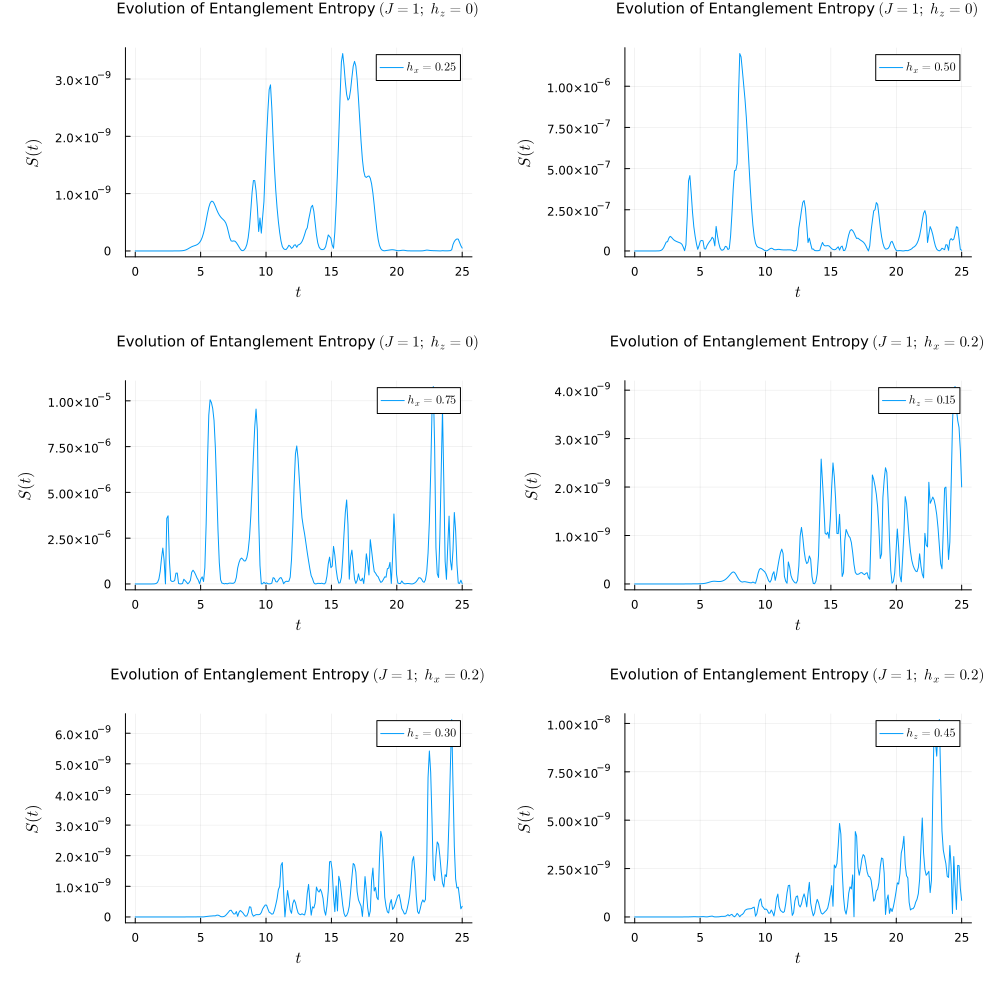

In [24]:
plot(En1[1], En1[2], En1[3], En2[1], En2[2], En2[3], legend=:topright, layout = (3,2), size = (1000,1000), margin = 5*Plots.mm)

In [25]:
savefig("Task 5")

"D:\\M.Sc. Courses\\3. SoSe 2022\\4. Data Analysis in Physics and Astronomy\\Exercises\\Task 5.png"

As one can see, for the case where only the longitudinal field is turned on, the entanglement entropy rises and falls over time with varying amplitudes of the rise. As is the case when both transverse and longitudinal components are turned on, but here, on average the rise of the amplitudes increase with time, i.e, as time progresses, we see bigger peaks. A further thing to note is that in both cases, this entanglement entropy is rather weak $\left(\leq \mathcal{O}\left(10^{-5}\right)\right)$, but in the latter cases even weaker so $\left(\leq \mathcal{O}\left(10^{-8}\right)\right)$ by several orders of magnitude.

## Task 6

In this particular task, it was unclear what the task itself was. While the manual asks for the Fourier transform of the magnetisation defined as $M^i(t) = \langle Z^i \rangle_{|\psi(t) \rangle}$, the reference [paper](https://www.nature.com/articles/nphys3934) defines it as $M^i(t) = \langle X^i \rangle_{|\psi(t) \rangle}$ and the power spectrum here is for the magnetisation they define, but the [supplementary information](https://static-content.springer.com/esm/art%3A10.1038%2Fnphys3934/MediaObjects/41567_2017_BFnphys3934_MOESM14_ESM.pdf) sets up the same plots for the entanglement entropy. Based on the plots, it would appear that the peaks on the right-side of the power spectrum corresspond to the meson masses, but it is unclear as to which plot one must find the peaks for. Only the magnetisation power spectrum has been generated below $(J = 1, h_x = 0.2, h_z = 0.3)$. The parameters are changable in accordance to how the objects have been defined in the previous tasks.

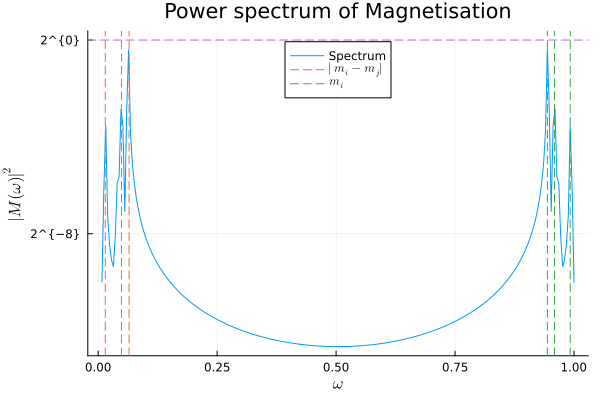

In [91]:
M = fft(map(x -> M4[2][4][Int(x*10)], collect(0.1:0.1:25)))
σm = [abs2(M[i]) for i in 2:250]
ωm = [t/250 for t in 2:250]

plot(ωm, σm, yaxis =:log2, legend=:top, label = "Spectrum")
title!("Power spectrum of Magnetisation")
xlabel!(L"$\omega$")
ylabel!(L"$|M(\omega)|^2$")
vline!([0.015, 0.049, 0.065], linestyle=:dash, label = L"$|m_i - m_j|$")
vline!([0.944, 0.959, 0.992], linestyle=:dash, label = L"$m_i$")
hline!([1], linestyle=:dash, label = "")

In [93]:
savefig("Task 6")

"D:\\M.Sc. Courses\\3. SoSe 2022\\4. Data Analysis in Physics and Astronomy\\Exercises\\Task 6.png"

## Task 7

For this task, we must first be able to generate our full basis, which is given by the function below.

In [3]:
function basis(N = L)
    b = Vector{SparseVector}()
    ψ = spzeros(2^N)
    ψ[1] = 1
    
    for i in 0:2^N-1
        push!(b, circshift(ψ,i))
    end
    
    return b
end

basis (generic function with 2 methods)

Next, we define a function that returns the overlap probabilities of a given state onto any of the basis states in an array.

In [4]:
function probabilities(ψ)
    P = Float64[]
    b = basis()
    for i in 1:length(ψ)
        push!(P,abs2(dot(ψ,b[i])))
    end
    
    return P
end

probabilities (generic function with 1 method)

Next, we define a new function to compute the magnetisation, but instead of computing the expectation value directly this computes the sample mean instead. We decidedly keep the sample size $2^N$ which is the dimension of our basis space for accurate results as every measurement outcome, if ideal would enumerate our basis with weights coressponding to the overlap probabilities.

In [5]:
function mag_sample(index, ψ_t; N = L)
    i = index
    
    Z = sparse([1 0; 0 -1])
    I = sparse([1 0; 0 1])
    
    m = fill(I, N)
    m[i] = Z
    M = spzeros(Int, 2^N, 2^N)
    
    M += foldl(kron,m)

    sample_size = 2^N
    M_ψ = sample(basis(), Weights(probabilities(ψ_t)), sample_size)
    sum = 0
    
    for j in 1:length(M_ψ)
        sum += dot(M_ψ[j], M, M_ψ[j])
    end
    
    mean = sum/length(M_ψ)
    
    return mean
end

mag_sample (generic function with 1 method)

To check the accuracy of our results we assume that we have a number of identical ground states prepared and we measure the magnetisation for each system independently according to the above prescription. Each system is allowed to evolve in an integer multiple of the trotter step $\Delta t$ we choose in **Task 2**. We do this in order to compare the results of all the measurements as a function of time against the expectation values we plotted earlier. We do this for the case, $(J = 1, h_x = 0.5, h_z = 0)$. The user can modify the choice of parameters in the codeblocks below in order to check other trends.

In [12]:
M3s = Any[]
t = 25
params3 = [[1.0, 0.25, 0.0], [1.0, 0.5, 0.0], [1.0, 0.75, 0.0]]
L = 10
for k in 1:3
    M = Any[]
    A = Any[]
    n = t*10
    
    for i in 1:n
        ψ = time_evolve(0.1*i, parameters = params3[k], N = L)
        M_j = Float64[]
        for j in 1:L
            push!(M_j, mag_sample(j, ψ))
        end
        push!(M, M_j)
    end
    
    for j in 1:L
        push!(A, [M[i][j] for i in 1:n])
    end
    push!(M3s,A)
end

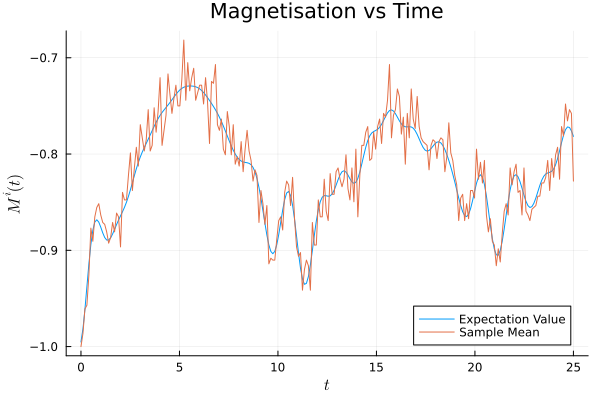

In [19]:
time = range(0, 25, length = 250)
gr()

P = plot(time, M3[2][4], label = "Expectation Value")
plot!(time, M3s[2][4], label = "Sample Mean")
title!("Magnetisation vs Time")
xlabel!(L"$t$")
ylabel!(L"$M^i(t)$")

As one would expect, the sample means in the plot appear as deviations from the expectation value but follow the same trend.